# Multimodal Chart-To-Text Generator
Modern decision-making frequently relies on charts and plots to summarize large datasets. While humans can easily interpret trends and values from charts, most language models struggle to reason over visual data without explicit multimodal support.

This project focuses on chart-to-text generation, where the goal is to generate accurate natural-language answers to questions about charts. This task requires joint visual understanding and language reasoning, making it a strong benchmark for multimodal models.

We fine-tune InternVL2-1B, a vision-language model, on the ChartQA dataset using parameter-efficient fine-tuning (LoRA) to improve chart-specific reasoning while keeping computational requirements manageable.


In [ ]:
# install some dependencies
!pip install datasets pillow pandas tqdm matplotlib

# Data Preprocessing & Augmentation
In this section, we load the ChartQA dataset from Hugging Face. ChartQA is a multimodal benchmark consisting of chart images paired with natural language questions and short textual or numeric answers. The dataset is split into training, validation, and test sets. We inspect the column structure of each split to understand the available fields and verify the expected schema before proceeding with preprocessing.

Before proceeding, we perform a sanity check by randomly sampling an example from the dataset. We display the chart image along with its corresponding question and answer. This qualitative inspection verifies that the images, labels, and metadata were saved correctly and provides intuition about the complexity of the ChartQA task

Loading dataset: HuggingFaceM4/ChartQA


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/852 [00:00<?, ?B/s]

data/train-00000-of-00003-49492f364babfa(…):   0%|          | 0.00/219M [00:00<?, ?B/s]

data/train-00001-of-00003-7302bae5e425bb(…):   0%|          | 0.00/311M [00:00<?, ?B/s]

data/train-00002-of-00003-194c9400785577(…):   0%|          | 0.00/315M [00:00<?, ?B/s]

data/val-00000-of-00001-0f11003c77497969(…):   0%|          | 0.00/50.2M [00:00<?, ?B/s]

data/test-00000-of-00001-e2cd0b7a0f9eb20(…):   0%|          | 0.00/68.9M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/28299 [00:00<?, ? examples/s]

Generating val split:   0%|          | 0/1920 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2500 [00:00<?, ? examples/s]


=== Column names per split ===
train: ['image', 'query', 'label', 'human_or_machine']
val: ['image', 'query', 'label', 'human_or_machine']
test: ['image', 'query', 'label', 'human_or_machine']

Saving train images + metadata...


100%|██████████| 28299/28299 [15:31<00:00, 30.38it/s]



Saving val images + metadata...


100%|██████████| 1920/1920 [01:01<00:00, 31.25it/s]



Saving test images + metadata...


100%|██████████| 2500/2500 [01:19<00:00, 31.64it/s]



=== Saved files ===
train:
  csv: chartqa_local/metadata/train.csv
  jsonl: chartqa_local/metadata/train.jsonl
val:
  csv: chartqa_local/metadata/val.csv
  jsonl: chartqa_local/metadata/val.jsonl
test:
  csv: chartqa_local/metadata/test.csv
  jsonl: chartqa_local/metadata/test.jsonl

=== Sample from test ===
Question: How many factors are shown in the chart?
Answer:   3
Origin:   0


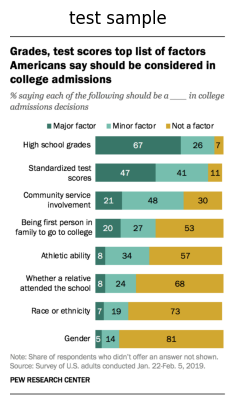

In [ ]:
# pip install datasets pillow pandas tqdm matplotlib

import os, random, json
from pathlib import Path

import pandas as pd
from datasets import load_dataset
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt

# settings
HF_ID = "HuggingFaceM4/ChartQA"
OUT_DIR = Path("chartqa_local")           # where to save everything
IMG_DIR = OUT_DIR / "images"              # images/<split>/*.png
META_DIR = OUT_DIR / "metadata"           # metadata CSV/JSON per split
META_DIR.mkdir(parents=True, exist_ok=True)

print(f"Loading dataset: {HF_ID}")
ds = load_dataset(HF_ID)  # splits: train / val / test

# column names
print("\n=== Column names per split ===")
for split in ds:
    print(f"{split}: {ds[split].column_names}")

# save images + metadata
all_meta_paths = {}
for split in ds:
    split_ds = ds[split]
    split_img_dir = IMG_DIR / split
    split_img_dir.mkdir(parents=True, exist_ok=True)

    rows = []
    print(f"\nSaving {split} images + metadata...")
    for i, ex in enumerate(tqdm(split_ds, total=len(split_ds))):
        # image (PIL.Image.Image via datasets Image feature)
        img = ex["image"]
        base_name = None
        try:
            # datasets.Image keeps a 'path' when sourced from file
            base_name = Path(img.filename).name if getattr(img, "filename", None) else None
        except Exception:
            base_name = None
        if not base_name:
            base_name = f"{split}_{i:06d}.png"

        out_path = split_img_dir / base_name
        # PNG output
        img.convert("RGB").save(out_path, format="PNG")

        # label on HF is a list[str] of length 1; normalize to a plain string
        label = ex["label"]
        if isinstance(label, (list, tuple)) and len(label) == 1:
            label = label[0]

        rows.append({
            "image_path": str(out_path.as_posix()),
            "query": ex["query"],
            "label": label,
            "human_or_machine": ex["human_or_machine"],
        })

    # save metadata
    df = pd.DataFrame(rows)
    csv_path = META_DIR / f"{split}.csv"
    jsonl_path = META_DIR / f"{split}.jsonl"
    df.to_csv(csv_path, index=False)
    with open(jsonl_path, "w", encoding="utf-8") as f:
        for r in rows:
            f.write(json.dumps(r, ensure_ascii=False) + "\n")
    all_meta_paths[split] = {"csv": str(csv_path), "jsonl": str(jsonl_path)}

# summary
print("\n=== Saved files ===")
for split, paths in all_meta_paths.items():
    print(f"{split}:")
    for k, v in paths.items():
        print(f"  {k}: {v}")

# inspect a sample (random from test; falls back to train if needed)
sample_split = "test" if "test" in ds else "train"
ex = random.choice(list(ds[sample_split]))
img = ex["image"]
label = ex["label"][0] if isinstance(ex["label"], list) and ex["label"] else ex["label"]

print(f"\n=== Sample from {sample_split} ===")
print("Question:", ex["query"])
print("Answer:  ", label)
print("Origin:  ", ex["human_or_machine"])

# show the image
plt.figure()
plt.imshow(img)
plt.axis("off")
plt.title(f"{sample_split} sample")
plt.show()

In [ ]:
!pip -q install -U "transformers>=4.43" accelerate bitsandbytes peft datasets pandas pillow tqdm matplotlib albumentations ms-swift
import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.8/52.8 kB 4.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.3/43.3 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 298.8/298.8 kB 24.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.7/89.7 kB 8.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 449.6/449.6 kB 25.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.1/59.1 MB 38.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 121.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 133.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 65.9 MB/s eta 0:00:00

In [ ]:
from pathlib import Path

# locally save the data
BASE   = Path("chartqa_local")
META   = BASE / "metadata"
IMAGES = BASE / "images"

train_csv = META / "train.csv"
val_csv   = META / "val.csv"  # if missing split
assert train_csv.exists(), f"Missing: {train_csv}"

To improve robustness and generalization, we apply image-level data augmentation to the chart images. Since charts may vary in color schemes, resolution, and rendering artifacts, augmentations such as brightness and contrast adjustments, color jitter, Gaussian blur, and compression artifacts help the model learn invariant visual representations without altering semantic content.

InternVL is trained using a chat-based multimodal instruction format. Each data sample is converted into a structured JSON format consisting of a user message containing an image token and a question, and an assistant message containing the ground-truth answer. Augmented images are saved and referenced explicitly, producing JSONL files compatible with supervised fine-tuning.

In [ ]:
import json, uuid
import numpy as np
import pandas as pd
from tqdm import tqdm
from PIL import Image
from pathlib import Path
import albumentations as A
import random

random.seed(42)
np.random.seed(42)

out_dir = Path("prepared_aug_full_clean")
out_dir.mkdir(parents=True, exist_ok=True)
AUG_IMG_DIR = out_dir / "images_aug"
AUG_IMG_DIR.mkdir(parents=True, exist_ok=True)

augment = A.Compose([
    A.LongestMaxSize(max_size=448, p=1.0),

    A.OneOf([
        A.RandomBrightnessContrast(brightness_limit=0.15, contrast_limit=0.15),
        A.ColorJitter(brightness=0.15, contrast=0.15, saturation=0.10, hue=0.02),
        A.CLAHE(clip_limit=2.0, tile_grid_size=(8,8)),
        A.RGBShift(r_shift_limit=10, g_shift_limit=10, b_shift_limit=10),
        A.ToGray(),
    ], p=0.9),

    A.GaussianBlur(blur_limit=3, p=0.20),
    A.ImageCompression(quality_range=(70, 100), p=0.30),
])


df_train = pd.read_csv(train_csv)
df_val   = pd.read_csv(val_csv) if val_csv.exists() else None

required_cols = {"image_path","query","label","human_or_machine"}
missing = required_cols - set(df_train.columns)
assert not missing, f"train.csv missing columns: {missing}"

# If no val file, carve 5% for dev
if df_val is None:
    df_train = df_train.sample(frac=1.0, random_state=42).reset_index(drop=True)
    cut = max(1, int(0.05 * len(df_train)))
    df_val = df_train.iloc[:cut].copy()
    df_train = df_train.iloc[cut:].copy()
else:
    df_val = df_val.copy()

def to_messages(row):
    return [
        {"role": "user", "content": f"<image>\n{row['query']}"},
        {"role": "assistant", "content": str(row['label'])},
    ]

def apply_aug_and_save(src_path: Path) -> Path:
    img = Image.open(src_path).convert("RGB")
    aug_np = augment(image=np.array(img))["image"]
    aug_img = Image.fromarray(aug_np)
    out_name = f"{src_path.stem}_{uuid.uuid4().hex[:8]}_aug.png"
    out_path = AUG_IMG_DIR / out_name
    aug_img.save(out_path)
    return out_path

def make_jsonl(df: pd.DataFrame, jsonl_path: Path, split_name: str):
    n = 0
    with open(jsonl_path, "w", encoding="utf-8") as f:
        for _, r in tqdm(df.iterrows(), total=len(df)):
            p = Path(r["image_path"])
            if not p.exists():
                maybe = IMAGES / p.name
                if maybe.exists():
                    p = maybe
                else:
                    continue

            aug_path = apply_aug_and_save(p)

            sample = {
                "messages": to_messages(r),
                "images": [str(aug_path.as_posix())],
                "meta": {"split": split_name, "human_or_machine": r.get("human_or_machine", None)}
            }
            f.write(json.dumps(sample, ensure_ascii=False) + "\n")
            n += 1
    return n

train_jsonl = out_dir / "chartqa_train_aug_full.jsonl"
val_jsonl   = out_dir / "chartqa_val_aug_full.jsonl"

ntr = make_jsonl(df_train, train_jsonl, "train")
nva = make_jsonl(df_val,   val_jsonl,   "val")
print(f"Augmented samples -> train: {ntr}, val: {nva}")
print(train_jsonl, val_jsonl)

100%|██████████| 1920/1920 [00:38<00:00, 49.49it/s]

Augmented samples -> train: 28299, val: 1920
prepared_aug_full_clean/chartqa_train_aug_full.jsonl prepared_aug_full_clean/chartqa_val_aug_full.jsonl


To verify that preprocessing and formatting were performed correctly, we inspect a sample from the prepared training JSONL file. This step confirms that the instruction format, image paths, and labels are aligned with the model’s expected input format.

In [ ]:
import json, itertools
with open(train_jsonl, "r", encoding="utf-8") as f:
    for line in itertools.islice(f, 1):
        print(json.loads(line))

{'messages': [{'role': 'user', 'content': '<image>\nIs the value of Favorable 38 in 2015?'}, {'role': 'assistant', 'content': 'Yes'}], 'images': ['prepared_aug_full_clean/images_aug/train_000000_f0d01847_aug.png'], 'meta': {'split': 'train', 'human_or_machine': 0}}


# Baseline: InternVL2-1B Model
We load the pretrained InternVL2-1B model and tokenizer. InternVL2-1B is a vision-language model designed for multimodal reasoning tasks such as visual question answering and document understanding. The model is loaded using bfloat16 precision and automatic device placement to balance performance and memory efficiency.

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModel

BASE_MODEL = "OpenGVLab/InternVL2-1B"

tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL, trust_remote_code=True)

baseline_model = AutoModel.from_pretrained(
    BASE_MODEL,
    trust_remote_code=True,
    torch_dtype=torch.bfloat16,
    device_map="auto",
    low_cpu_mem_usage=True,
    use_flash_attn=True,   # set False if it errors
).eval()

# Try to fetch preprocessing helpers from the base model
build_transform = getattr(baseline_model, "build_transform", None)
dynamic_preprocess = getattr(baseline_model, "dynamic_preprocess", None)

# fallback
if build_transform is None or dynamic_preprocess is None:
    import torchvision.transforms as T
    from PIL import Image

    def _fallback_build_transform(input_size=448):
        return T.Compose([
            T.Resize(input_size, interpolation=T.InterpolationMode.BICUBIC),
            T.CenterCrop(input_size),
            T.ToTensor(),
            T.Normalize(mean=(0.48145466, 0.4578275, 0.40821073),
                        std=(0.26862954, 0.26130258, 0.27577711)),
        ])

    def _fallback_dynamic_preprocess(img: Image.Image, image_size=448, use_thumbnail=True, max_num=1):
        if use_thumbnail:
            thumb = img.copy()
            thumb.thumbnail((image_size, image_size), Image.BICUBIC)
            canvas = Image.new("RGB", (image_size, image_size), (255, 255, 255))
            x = (image_size - thumb.width) // 2
            y = (image_size - thumb.height) // 2
            canvas.paste(thumb, (x, y))
            return [canvas]
        else:
            return [img.resize((image_size, image_size), Image.BICUBIC)]

    build_transform = _fallback_build_transform
    dynamic_preprocess = _fallback_dynamic_preprocess

transform = build_transform(input_size=448)

device = next(baseline_model.parameters()).device
print("Baseline model ready on:", device)


Baseline model ready on: cuda:0


Before fine-tuning, we evaluate the pretrained InternVL2-1B model on the validation split to establish a baseline. Predictions are generated using the model’s chat interface, and answers are normalized to enable exact-match comparison. This baseline provides a reference point for measuring the impact of fine-tuning.

In [ ]:
import json, re
from pathlib import Path
from PIL import Image
import torch
from tqdm import tqdm

# normalize answers
def normalize(text):
    if text is None:
        return ""
    text = str(text).strip().lower()
    text = re.sub(r"[^a-z0-9\.\-\s]", "", text)
    text = " ".join(text.split())
    return text

# load validation JSONL
VAL_JSONL = Path("prepared_aug_full_clean/chartqa_val_aug_full.jsonl")

if not VAL_JSONL.exists():
    cands = list(Path(".").rglob("chartqa_val*.jsonl"))
    if not cands:
        raise FileNotFoundError("Validation JSONL not found.")
    VAL_JSONL = cands[0]
    print("Auto-found validation:", VAL_JSONL)

with open(VAL_JSONL, "r", encoding="utf-8") as f:
    val_items = [json.loads(x) for x in f]

print("Loaded", len(val_items), "validation samples.")


# Evaluate baseline InternVL2
correct = 0
total = len(val_items)
results = []

for item in tqdm(val_items):
    img_path = item["images"][0]
    question = item["messages"][0]["content"]   # "<image>\n..."
    gold = item["messages"][1]["content"]

    # load image
    img = Image.open(img_path).convert("RGB")

    # preprocess image
    tiles = dynamic_preprocess(
        img,
        image_size=448,
        use_thumbnail=True,
        max_num=1
    )

    pixel_values = torch.stack([transform(t) for t in tiles]) \
                         .to(torch.bfloat16) \
                         .to(device)

    num_patches_list = [pixel_values.shape[0]]

    # inference
    with torch.no_grad():
        pred, _ = baseline_model.chat(
            tokenizer=tokenizer,
            pixel_values=pixel_values,
            question=question,
            num_patches_list=num_patches_list,
            generation_config=dict(
                max_new_tokens=64,
                do_sample=False
            ),
            return_history=True,
        )

    # normalize answers
    norm_pred = normalize(pred)
    norm_gold = normalize(gold)

    is_correct = (norm_pred == norm_gold)
    correct += int(is_correct)

    results.append((img_path, pred, gold, is_correct))


accuracy = correct / total * 100

print("\n=================================")
print(f"Baseline Validation Accuracy: {accuracy:.2f}%  ({correct}/{total})")
print("=================================\n")


Loaded 1920 validation samples.


100%|██████████| 1920/1920 [33:04<00:00,  1.03s/it]


Baseline Validation Accuracy: 4.69%  (90/1920)



In [ ]:
!pip -q install watchdog

During fine-tuning, model checkpoints are saved periodically. This section sets up an automated watcher that detects newly created checkpoint directories, compresses them, and makes them available for download. This is especially useful in Colab environments where sessions may disconnect unexpectedly.

In [ ]:
import os, time, shutil, threading
from pathlib import Path
from IPython.display import display, FileLink

# detect Colab for auto-download
try:
    from google.colab import files as colab_files
    IS_COLAB = True
except Exception:
    IS_COLAB = False
    colab_files = None

# user settings
OUTPUT_DIR = Path("outputs/internvl2-1b-chartqa-qlora-aug-full-clean")  # <- set to your output_dir
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
ZIP_OUT = OUTPUT_DIR / "zips"
ZIP_OUT.mkdir(exist_ok=True)

READY_MARKERS = {
    "pytorch_model.bin",            # merged weights style
    "adapter_config.json",          # PEFT adapter
    "adapter_model.bin",            # PEFT adapter weights
    "model.safetensors",            # safetensors variant
    "pytorch_model.safetensors",    # another variant
    "trainer_state.json",           # sometimes present in the folder
}

# keep a cache of what we've zipped
_seen = set()
_stop_flag = False

def _is_checkpoint_dir(path: Path) -> bool:
    if not path.is_dir():
        return False

    for marker in READY_MARKERS:
        if (path / marker).exists():
            return True

    return False

def _zip_and_offer(path: Path):

    zip_name = ZIP_OUT / f"{path.name}.zip"
    if zip_name.exists():
        return zip_name

    base = str(zip_name.with_suffix(""))  # drop .zip suffix for make_archive
    shutil.make_archive(base, "zip", root_dir=str(path))
    return zip_name

def _wait_until_ready(path: Path, timeout=600, poll=1.0):
    # Poll until at least one marker appears or timeout
    start = time.time()
    while time.time() - start < timeout and not _is_checkpoint_dir(path):
        time.sleep(poll)
    return _is_checkpoint_dir(path)

def _offer_download(zip_path: Path):
    if IS_COLAB and colab_files is not None:
        try:
            colab_files.download(str(zip_path))
        except Exception:

            display(FileLink(str(zip_path), result_html_prefix="Download: "))
    else:
        display(FileLink(str(zip_path), result_html_prefix="Download: "))

def _watch_loop():
    # polling watcher
    while not _stop_flag:
        try:
            for sub in OUTPUT_DIR.iterdir():
                if not sub.is_dir():
                    continue
                if sub in _seen:
                    continue

                if _wait_until_ready(sub, timeout=120, poll=1.0):
                    _seen.add(sub)
                    zip_path = _zip_and_offer(sub)
                    _offer_download(zip_path)
        except Exception as e:
            # keep watcher alive
            print(f"[watcher] Warning: {e}")
        time.sleep(2.0)

_watcher_thread = threading.Thread(target=_watch_loop, daemon=True)
_watcher_thread.start()
print("Checkpoint watcher started. New epoch folders will be zipped and offered for download automatically.")
print(f"Watching: {OUTPUT_DIR}")

✅ Checkpoint watcher started. New epoch folders will be zipped and offered for download automatically.
Watching: outputs/internvl2-1b-chartqa-qlora-aug-full-clean


# Finetuning

We fine-tune InternVL2-1B using LoRA-based parameter-efficient training via MS-Swift. Only a small subset of parameters is updated while the base model remains frozen. Training is performed with 4-bit quantization, gradient accumulation, and gradient checkpointing to reduce memory usage. Although a maximum number of epochs is specified, training is step-limited internally to ensure stability.

In [ ]:

MAX_EPOCHS = 9
LR         = 2e-4
BATCH      = 1

!swift sft \
  --use_hf true \
  --model OpenGVLab/InternVL2-1B \
  --dataset "{train_jsonl}" "{val_jsonl}" \
  --train_type lora \
  --quant_method bnb --quant_bits 4 --bnb_4bit_compute_dtype bfloat16 \
  --torch_dtype bfloat16 --bf16 true \
  --gradient_checkpointing true \
  --per_device_train_batch_size {BATCH} \
  --per_device_eval_batch_size {BATCH} \
  --gradient_accumulation_steps 8 \
  --learning_rate {LR} \
  --max_epochs {MAX_EPOCHS} \
  --max_length 8192 \
  --truncation_strategy right \
  --model_kwargs '{{"max_num": 1, "image_size": 448}}' \
  --save_strategy "epoch" \
  --eval_strategy "epoch" \
  --logging_steps 10 \
  --report_to "tensorboard" \
  --output_dir {OUTPUT_DIR}

run sh: `/usr/bin/python3 /usr/local/lib/python3.12/dist-packages/swift/cli/sft.py --use_hf true --model OpenGVLab/InternVL2-1B --dataset prepared_aug_full_clean/chartqa_train_aug_full.jsonl prepared_aug_full_clean/chartqa_val_aug_full.jsonl --train_type lora --quant_method bnb --quant_bits 4 --bnb_4bit_compute_dtype bfloat16 --torch_dtype bfloat16 --bf16 true --gradient_checkpointing true --per_device_train_batch_size 1 --per_device_eval_batch_size 1 --gradient_accumulation_steps 8 --learning_rate 0.0002 --max_epochs 9 --max_length 8192 --truncation_strategy right --model_kwargs {"max_num": 1, "image_size": 448} --save_strategy epoch --eval_strategy epoch --logging_steps 10 --report_to tensorboard --output_dir outputs/internvl2-1b-chartqa-qlora-aug-full-clean`
2025-12-14 08:13:14.214463: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn 

In [ ]:
_stop_flag = True
if _watcher_thread.is_alive():
    _watcher_thread.join(timeout=5.0)
print("Checkpoint watcher stopped.")

🛑 Checkpoint watcher stopped.


In [ ]:
!pip -q uninstall -y Pillow pillow-simd
!pip -q install -U Pillow
!pip -q install -U transformers accelerate peft bitsandbytes torchvision gdown


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gradio 5.50.0 requires pillow<12.0,>=8.0, but you have pillow 12.0.0 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.0/8.0 MB 145.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 899.7/899.7 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 594.3/594.3 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 156.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.0/88.0 MB 30.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 954.8/954.8 kB 71.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.1/193.1 MB 13.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 78.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.6/63.6 MB 39.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━

In [ ]:
!pip -q install -U "transformers>=4.43" accelerate bitsandbytes peft pillow gdown

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 139.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gradio 5.50.0 requires pillow<12.0,>=8.0, but you have pillow 12.0.0 which is incompatible.


In [ ]:
import os, zipfile, tarfile
from pathlib import Path
import gdown

# download
DRIVE_URL = "https://drive.google.com/file/d/1rRW0pume8xVQNV9qDscOrtrePh-H38f4/view?usp=sharing"
ROOT = Path("ckpt_dl")
ROOT.mkdir(exist_ok=True)

ARCHIVE_PATH = ROOT / "checkpoint_archive"
gdown.download(DRIVE_URL, output=str(ARCHIVE_PATH), fuzzy=True)
print("Downloaded:", ARCHIVE_PATH)

# extract archive
EXTRACTED = ROOT / "extracted"
EXTRACTED.mkdir(exist_ok=True)

def extract_any(path, dest):
    if zipfile.is_zipfile(path):
        with zipfile.ZipFile(path, "r") as z:
            z.extractall(dest)
        return True
    if tarfile.is_tarfile(path):
        with tarfile.open(path, "r:*") as t:
            t.extractall(dest)
        return True
    return False

if extract_any(ARCHIVE_PATH, EXTRACTED):
    SEARCH_ROOT = EXTRACTED
    print("Extracted to:", EXTRACTED)
else:
    SEARCH_ROOT = ROOT
    print("No archive structure; using:", SEARCH_ROOT)

SEARCH_ROOT = SEARCH_ROOT.resolve()
print("SEARCH_ROOT =", SEARCH_ROOT)

# find adapter directory
def find_adapter_dir(root: Path):
    hits = []
    for dp, dn, fn in os.walk(root):
        fn = set(fn)
        if (
            "adapter_model.safetensors" in fn or
            "adapter_model.bin" in fn or
            "adapter_config.json" in fn
        ):
            hits.append(Path(dp))

    if not hits:
        return None

    # Prefer the one containing 'checkpoint-3778'
    hits = sorted(hits, key=lambda p: ("checkpoint-3778" not in str(p)))
    return hits[0]

ADAPTER_DIR = find_adapter_dir(SEARCH_ROOT)
print("FOUND ADAPTER DIR:", ADAPTER_DIR)
assert ADAPTER_DIR is not None, "Adapter directory not found!"

Downloading...
From (original): https://drive.google.com/uc?id=1rRW0pume8xVQNV9qDscOrtrePh-H38f4
From (redirected): https://drive.google.com/uc?id=1rRW0pume8xVQNV9qDscOrtrePh-H38f4&confirm=t&uuid=018c38b6-76e3-46ca-a88b-e74a953ba296
To: /content/ckpt_dl/checkpoint_archive
100%|██████████| 48.9M/48.9M [00:00<00:00, 236MB/s]


Downloaded: ckpt_dl/checkpoint_archive
Extracted to: ckpt_dl/extracted
SEARCH_ROOT = /content/ckpt_dl/extracted
FOUND ADAPTER DIR: /content/ckpt_dl/extracted/content/outputs/internvl2-1b-chartqa-qlora-aug-full-clean/v0-20251213-141406/checkpoint-3778


After training, we load the LoRA adapter and attach it to the base InternVL2 model for inference. This modular design allows us to evaluate the fine-tuned model without modifying the original pretrained weights.

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModel
from peft import PeftModel

BASE_MODEL = "OpenGVLab/InternVL2-1B"

tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL, trust_remote_code=True)

# load base first
base_model = AutoModel.from_pretrained(
    BASE_MODEL,
    trust_remote_code=True,
    torch_dtype=torch.bfloat16,
    device_map="auto",
    low_cpu_mem_usage=True,
    use_flash_attn=True,
).eval()

# try to fetch preprocessing helpers from the base model
build_transform = getattr(base_model, "build_transform", None)
dynamic_preprocess = getattr(base_model, "dynamic_preprocess", None)

# Attach LoRA adapter
model = PeftModel.from_pretrained(
    base_model,
    ADAPTER_DIR,
    is_trainable=False
).eval()


if build_transform is None or dynamic_preprocess is None:
    # Try to reach into the wrapped base
    inner = getattr(model, "base_model", None) or getattr(model, "model", None)
    build_transform = build_transform or getattr(inner, "build_transform", None)
    dynamic_preprocess = dynamic_preprocess or getattr(inner, "dynamic_preprocess", None)

# fallback
if build_transform is None or dynamic_preprocess is None:
    import torchvision.transforms as T
    from PIL import Image

    def _fallback_build_transform(input_size=448):
        # Resize -> center crop/pad to 448 -> to tensor -> normalize
        return T.Compose([
            T.Resize(input_size, interpolation=T.InterpolationMode.BICUBIC),
            T.CenterCrop(input_size),
            T.ToTensor(),
            T.Normalize(mean=(0.48145466, 0.4578275, 0.40821073),
                        std=(0.26862954, 0.26130258, 0.27577711)),
        ])

    def _fallback_dynamic_preprocess(img: Image.Image, image_size=448, use_thumbnail=True, max_num=1):
        # return a list with a single image resized to image_size (no tiling)
        if use_thumbnail:
            # thumbnail keeps aspect ratio, then paste to a square canvas
            thumb = img.copy()
            thumb.thumbnail((image_size, image_size), Image.BICUBIC)
            canvas = Image.new("RGB", (image_size, image_size), (255, 255, 255))
            x = (image_size - thumb.width) // 2
            y = (image_size - thumb.height) // 2
            canvas.paste(thumb, (x, y))
            return [canvas]
        else:
            return [img.resize((image_size, image_size), Image.BICUBIC)]

    build_transform = _fallback_build_transform
    dynamic_preprocess = _fallback_dynamic_preprocess

# finalize transform & device
transform = build_transform(input_size=448)
device = next(model.parameters()).device
print("Model ready on:", device)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
A new version of the following files was downloaded from https://huggingface.co/OpenGVLab/InternVL2-1B:
- configuration_intern_vit.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
`torch_dtype` is deprecated! Use `dtype` instead!
A new version of the following files was downloaded from https://huggingface.co/OpenGVLab/InternVL2-1B:
- modeling_intern_vit.py
- conversation.py
.

FlashAttention2 is not installed.
Model ready on: cuda:0


We perform qualitative evaluation by sampling a small number of validation examples and inspecting model predictions. This helps identify improvements in chart understanding, numeric accuracy, and alignment with ground-truth answers beyond what is captured by aggregate metrics.

In [ ]:
import json, random
from pathlib import Path
from PIL import Image

# Point this at your validation JSONL - auto-discover if missing
VAL_JSONL = Path("prepared_aug_full_clean/chartqa_val_aug_full.jsonl")
if not VAL_JSONL.exists():
    cands = list(Path(".").rglob("chartqa_val*.jsonl"))
    if not cands:
        raise FileNotFoundError("Validation JSONL not found. Set VAL_JSONL to the correct path.")
    VAL_JSONL = cands[0]
    print("Using discovered val JSONL:", VAL_JSONL)

with open(VAL_JSONL, "r", encoding="utf-8") as f:
    val_items = [json.loads(x) for x in f]

random.seed(0)
batch = random.sample(val_items, k=min(5, len(val_items)))

def run_one(item):
    img_path = item["images"][0]
    question = item["messages"][0]["content"]
    gold = item["messages"][1]["content"]

    img = Image.open(img_path).convert("RGB")

    tiles = dynamic_preprocess(img, image_size=448, use_thumbnail=True, max_num=1)
    pixel_values = torch.stack([transform(t) for t in tiles]).to(torch.bfloat16).to(device)
    num_patches_list = [pixel_values.shape[0]]

    with torch.no_grad():
        pred, _ = model.chat(
            tokenizer=tokenizer,
            pixel_values=pixel_values,
            question=question,
            generation_config=dict(max_new_tokens=64, do_sample=False),
            num_patches_list=num_patches_list,
            history=None,
            return_history=True,
        )
    return img_path, question.split("\n", 1)[-1], pred, gold

results = [run_one(x) for x in batch]
for i, (img_path, q, pred, gold) in enumerate(results, 1):
    print(f"\n===== Sample {i} =====")
    print("Image:", img_path)
    print("Q:", q)
    print("Pred:", pred)
    print("Gold:", gold)

Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.



===== Sample 1 =====
Image: prepared_aug_full_clean/images_aug/val_001729_7cd132ba_aug.png
Q: How many dollars did PR agencies generate with media relations services in 2019?
Pred: 1000
Gold: 764

===== Sample 2 =====
Image: prepared_aug_full_clean/images_aug/val_000788_7141af3c_aug.png
Q: What year was the price of germanium metal the highest?
Pred: 2014
Gold: 2014

===== Sample 3 =====
Image: prepared_aug_full_clean/images_aug/val_001552_52f94833_aug.png
Q: How many Serie A championships did Internazionale Milano win?
Pred: 18
Gold: 18

===== Sample 4 =====
Image: prepared_aug_full_clean/images_aug/val_001823_ae79acac_aug.png
Q: What accounts for the largest part of the 2021 budget?
Pred: 20000
Gold: HX Fighter Program

===== Sample 5 =====
Image: prepared_aug_full_clean/images_aug/val_000861_3662538a_aug.png
Q: Which year has the maximum traffic of smartphones?
Pred: 2017
Gold: 2017


# Evaluation

Finally, we evaluate the fine-tuned model on the full validation set using exact-match accuracy. Results are compared against the baseline to quantify improvements from LoRA fine-tuning. Incorrect predictions are logged for error analysis and future improvements.

In [ ]:
import json, re
from pathlib import Path
from PIL import Image
import torch
from tqdm import tqdm

def normalize(text):
    if text is None:
        return ""
    text = str(text).strip().lower()
    # remove punctuation except minus and decimal point
    text = re.sub(r"[^a-z0-9\.\-\s]", "", text)
    # collapse whitespace
    text = " ".join(text.split())
    return text

VAL_JSONL = Path("prepared_aug_full_clean/chartqa_val_aug_full.jsonl")

if not VAL_JSONL.exists():
    cands = list(Path(".").rglob("chartqa_val*.jsonl"))
    if not cands:
        raise FileNotFoundError("Validation JSONL not found. Set VAL_JSONL to correct path.")
    VAL_JSONL = cands[0]
    print("Auto-found validation:", VAL_JSONL)

with open(VAL_JSONL, "r", encoding="utf-8") as f:
    val_items = [json.loads(x) for x in f]

print("Loaded", len(val_items), "validation samples.")

correct = 0
total = len(val_items)
results = []

for item in tqdm(val_items):
    img_path = item["images"][0]
    question = item["messages"][0]["content"]
    gold = item["messages"][1]["content"]

    img = Image.open(img_path).convert("RGB")

    # preprocess image for InternVL2
    tiles = dynamic_preprocess(img, image_size=448, use_thumbnail=True, max_num=1)
    pixel_values = torch.stack([transform(t) for t in tiles]) \
                         .to(torch.bfloat16).to(device)
    num_patches_list = [pixel_values.shape[0]]

    with torch.no_grad():
        pred, _ = model.chat(
            tokenizer=tokenizer,
            pixel_values=pixel_values,
            question=question,
            num_patches_list=num_patches_list,
            generation_config=dict(
                max_new_tokens=64,
                do_sample=False
            ),
            return_history=True,
        )

    # normalize for exact matching
    norm_pred = normalize(pred)
    norm_gold = normalize(gold)

    is_correct = (norm_pred == norm_gold)
    correct += int(is_correct)

    results.append((img_path, pred, gold, is_correct))

accuracy = correct / total * 100
print(f"\n=================================")
print(f"Validation Accuracy: {accuracy:.2f}%  ({correct}/{total})")
print("=================================\n")

Loaded 1920 validation samples.


100%|██████████| 1920/1920 [11:22<00:00,  2.81it/s]


Validation Accuracy: 35.99%  (691/1920)



In [ ]:
print("Some mistakes:")
for (img, pred, gold, ok) in results:
    if not ok:
        print("\nImage:", img)
        print("Pred :", pred)
        print("Gold :", gold)

Some mistakes:

Image: prepared_aug_full_clean/images_aug/val_000001_5aceddd2_aug.png
Pred : 2006
Gold : 2018

Image: prepared_aug_full_clean/images_aug/val_000003_0c689ab1_aug.png
Pred : 71
Gold : 0.72

Image: prepared_aug_full_clean/images_aug/val_000009_99ca6bdd_aug.png
Pred : 3
Gold : 2

Image: prepared_aug_full_clean/images_aug/val_000011_d2a43772_aug.png
Pred : 46
Gold : 37

Image: prepared_aug_full_clean/images_aug/val_000012_9ec83af9_aug.png
Pred : Dec 2008
Gold : 44538

Image: prepared_aug_full_clean/images_aug/val_000013_4760a240_aug.png
Pred : 173
Gold : 155

Image: prepared_aug_full_clean/images_aug/val_000014_c8c3af3b_aug.png
Pred : Dec 2008
Gold : 44207

Image: prepared_aug_full_clean/images_aug/val_000015_11a33fcc_aug.png
Pred : 110
Gold : 87

Image: prepared_aug_full_clean/images_aug/val_000017_6f78387a_aug.png
Pred : 60
Gold : 79

Image: prepared_aug_full_clean/images_aug/val_000018_390585a6_aug.png
Pred : gray
Gold : Light blue

Image: prepared_aug_full_clean/images_a